<a href="https://colab.research.google.com/github/seansothey/CSC685/blob/master/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow import keras
import time
from datetime import timedelta
import math
import os

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [0]:
cifar10 = keras.datasets.cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [0]:
class_names = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

#Explore the data

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [8]:
num_classes = len(np.unique(y_train))
num_classes

10

#Preprocess the data

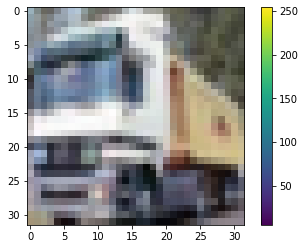

In [9]:
#View image #1
plt.figure()
plt.imshow(X_train[1])
plt.colorbar()
plt.grid(False)

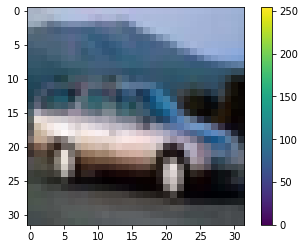

In [10]:
#View image #4
plt.figure()
plt.imshow(X_train[4])
plt.colorbar()
plt.grid(False)

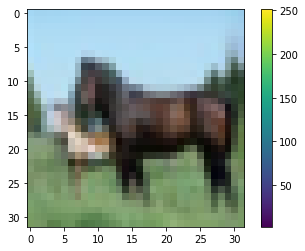

In [11]:
#View image #12
plt.figure()
plt.imshow(X_train[12])
plt.colorbar()
plt.grid(False)

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

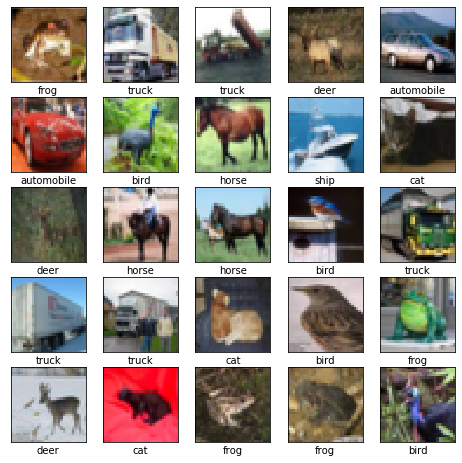

In [12]:
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])

Reshape dataset

In [0]:
nsamples, nx, ny, nz = X_train.shape
X_train_2d = X_train.reshape((nsamples,nx*ny*nz))

nsamples, nx, ny, nz = X_test.shape
X_test_2d = X_test.reshape((nsamples,nx*ny*nz))

nsamples, nx = y_train.shape
y_train_1d = y_train.reshape(nsamples)

nsamples, nx = y_test.shape
y_test_1d = y_test.reshape(nsamples)

In [14]:
X_train_2d.shape, X_test_2d.shape

((50000, 3072), (10000, 3072))

***Data normalization doesn't work for this dataset



#Apply PCA

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler1 = MinMaxScaler(feature_range=[0, 1])
X_train_scale = scaler1.fit_transform(X_train_2d[0:]) #select data from 0 to end
X_test_scale = scaler1.fit_transform(X_test_2d[0:]) #select data from 0 to end

In [0]:
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

In [17]:
X_train_pca.shape, X_test_pca.shape

((50000, 217), (10000, 217))

Now, new dataset has been reduced from (50000, 3072) to (50000, 217)

# Let's plot to see dataset

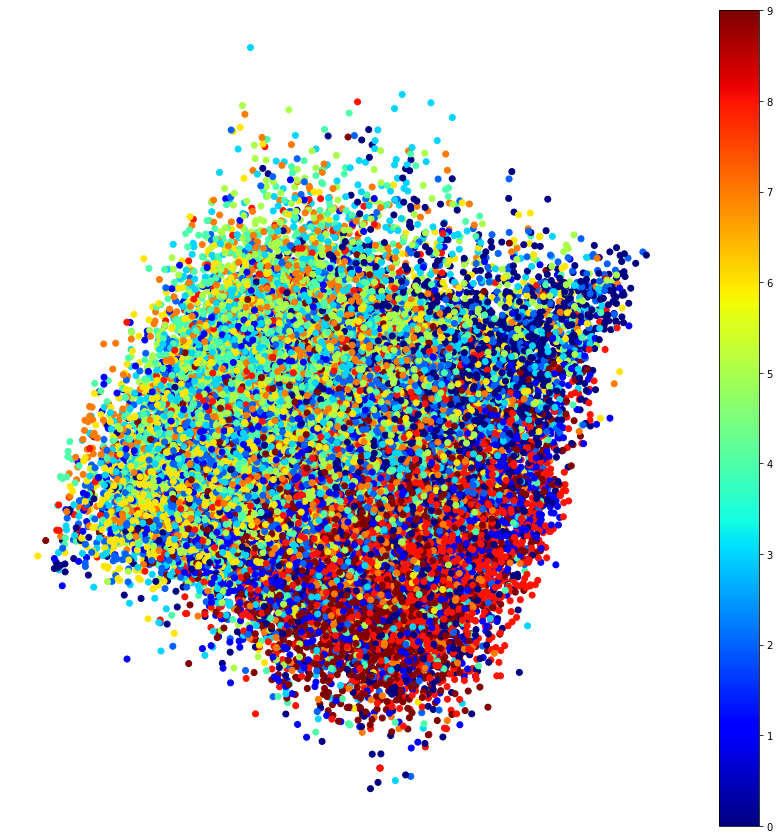

In [18]:
plt.figure(figsize=(15,15))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_1d, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

It is cleared that the dataset is very complex but not so sparse. 

#Multiclass classification RandomForest

In [0]:
# Create the learning model
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf.fit(X_train_pca, y_train_1d)
t1 = time.time()

In [20]:
#See the training time
t_rnd = t1-t0
print("Training took {:.2f}s".format(t_rnd))

Training took 104.54s


In [0]:
# Use the model to predict on testing dataset
y_test_pred = rnd_clf.predict(X_test_pca)
y_test_proba = rnd_clf.predict_proba(X_test_pca)

In [22]:
#See the accuracy on testing 
from sklearn.metrics import accuracy_score
accuracy_score(y_test_1d, y_test_pred)

0.4364

Let's see the prediction for the first 25 images (incorrect labels in red)

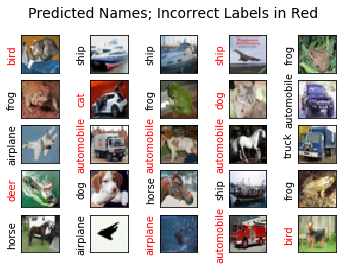

In [23]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i], cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(class_names[y_test_pred[i]].split()[-1],
                   color='black' if y_test_pred[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

This can be seen that the number of correct prediction is about 40%, just right to the accuracy rate.

#Confusion Matrix

In [24]:
conf_rf = confusion_matrix(y_test, y_test_pred)
conf_rf

array([[526,  56,  49,  45,  28,  21,  27,  23, 159,  66],
       [ 48, 556,  17,  37,  12,  33,  26,  29,  65, 177],
       [116,  43, 294,  86, 155,  80, 113,  51,  41,  21],
       [ 61,  58,  85, 248,  82, 197, 122,  60,  26,  61],
       [ 59,  19, 130,  78, 387,  46, 152,  72,  31,  26],
       [ 34,  42,  92, 174,  74, 345,  88,  64,  47,  40],
       [ 19,  27,  95,  71, 115,  77, 519,  22,  22,  33],
       [ 39,  58,  56,  82,  79,  86,  57, 414,  34,  95],
       [110,  84,  14,  39,  14,  25,  17,  28, 592,  77],
       [ 59, 200,  15,  40,  13,  31,  26,  49,  84, 483]])

# Plot confusion matrix

Text(0.5, 15.0, 'Predicted label')

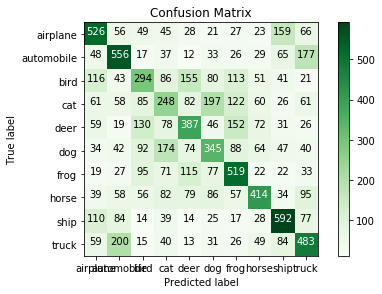

In [25]:
import itertools

plt.imshow(conf_rf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = conf_rf.max() / 2.
for i, j in itertools.product(range(conf_rf.shape[0]), range(conf_rf.shape[1])):
    plt.text(j, i, format(conf_rf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_rf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5, 1, 'Confusion Matrix')

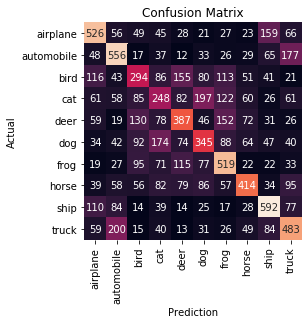

In [26]:
import seaborn as sns
mat = confusion_matrix(y_test_pred, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

#Sensitivity, Specificity and F1-Score 

In [27]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_test_pred,target_names=class_names, output_dict=True)
print(report)

{'airplane': {'precision': 0.4911297852474323, 'recall': 0.526, 'f1-score': 0.5079671656204732, 'support': 1000}, 'automobile': {'precision': 0.4864391951006124, 'recall': 0.556, 'f1-score': 0.5188987400839944, 'support': 1000}, 'bird': {'precision': 0.34710743801652894, 'recall': 0.294, 'f1-score': 0.31835408770979967, 'support': 1000}, 'cat': {'precision': 0.27555555555555555, 'recall': 0.248, 'f1-score': 0.26105263157894737, 'support': 1000}, 'deer': {'precision': 0.4035453597497393, 'recall': 0.387, 'f1-score': 0.39509954058192953, 'support': 1000}, 'dog': {'precision': 0.36663124335812963, 'recall': 0.345, 'f1-score': 0.35548686244204014, 'support': 1000}, 'frog': {'precision': 0.4524847428073234, 'recall': 0.519, 'f1-score': 0.48346530041918956, 'support': 1000}, 'horse': {'precision': 0.5098522167487685, 'recall': 0.414, 'f1-score': 0.45695364238410596, 'support': 1000}, 'ship': {'precision': 0.5376930063578564, 'recall': 0.592, 'f1-score': 0.5635411708710136, 'support': 1000}, 

In [28]:
import pandas as pd
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
airplane,0.491130,0.5260,0.507967,1000.0000
automobile,0.486439,0.5560,0.518899,1000.0000
bird,0.347107,0.2940,0.318354,1000.0000
cat,0.275556,0.2480,0.261053,1000.0000
deer,0.403545,0.3870,0.395100,1000.0000
dog,0.366631,0.3450,0.355487,1000.0000
frog,0.452485,0.5190,0.483465,1000.0000
horse,0.509852,0.4140,0.456954,1000.0000
ship,0.537693,0.5920,0.563541,1000.0000
truck,0.447637,0.4830,0.464646,1000.0000


#Perform Cross Validation with 3 folds

In [29]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(rnd_clf, X_train_pca, y_train_1d, cv=3, scoring="accuracy")
cv_score

array([0.42431151, 0.41759165, 0.41731669])

In [30]:
# See the average of CV
np.mean(cv_score)


0.41973995153482263

In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(rnd_clf, X_train_pca, y_train_1d, cv=3)

Confusion Matrix & Accuracy

In [32]:
conf_cv = confusion_matrix(y_train_1d, y_train_pred)
conf_cv

array([[2563,  331,  228,  161,  165,  149,  136,  157,  787,  323],
       [ 243, 2693,  101,  185,   68,  169,  170,  166,  348,  857],
       [ 531,  176, 1446,  412,  847,  367,  598,  249,  203,  171],
       [ 268,  311,  424, 1235,  351,  999,  590,  270,  213,  339],
       [ 329,  142,  769,  314, 1870,  258,  635,  334,  181,  168],
       [ 199,  256,  448,  949,  355, 1604,  449,  374,  155,  211],
       [ 108,  175,  433,  481,  650,  357, 2373,  161,   93,  169],
       [ 210,  295,  323,  407,  502,  460,  290, 1882,  156,  475],
       [ 589,  388,   96,  162,  100,  203,   79,   81, 2948,  354],
       [ 285, 1052,   93,  167,   66,  179,  131,  244,  410, 2373]])

In [33]:
#Pretend we reached perfection
y_train_perfect_predictions = y_train_1d
confusion_matrix(y_train_1d, y_train_perfect_predictions)

array([[5000,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 5000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5000,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 5000,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5000,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5000,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 5000,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5000,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5000]])

#Plot confusion matrix of Cross Validation

Text(0.5, 1, 'Confusion Matrix')

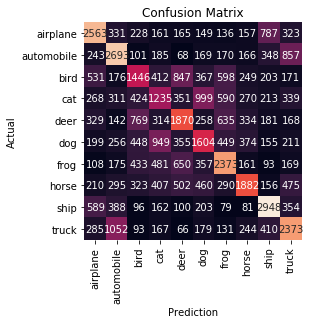

In [34]:
mat_cv = confusion_matrix(y_train_pred, y_train_1d)
sns.heatmap(mat_cv.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

#Plots sensitivity and specificity against the number of folds

In [0]:
from sklearn.metrics import precision_recall_curve, roc_curve
precision = report_df['precision']
recall = report_df['recall']

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PrecisionRecallCurve(ap_score=True,
                     ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0f88121d0>,
                     classes=None, fill_area=True, fill_opacity=0.2,
                     iso_f1_curves=False, line_opacity=0.8, micro=True,
                     model=None, per_class=False)


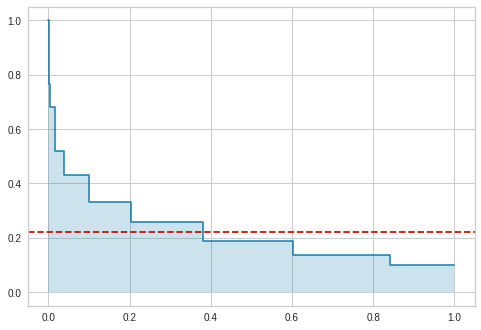

In [36]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(RandomForestClassifier(n_estimators=10))
viz.fit(X_train_pca, y_train)
viz.score(X_test_pca, y_test)
print(viz)

![alt text](https://drive.google.com/uc?id=1MPln68-6AFUqBve0FEAcG7mNEYg_AiCm)

#ROC curve (Receiver Operating Characteristic curve)

![alt text](https://drive.google.com/uc?id=1dZyM8NN_rak-GiT7v9xrYU1dPvU5ISAT)

#Multiclass classification SVM

In [37]:
# Create the learning model
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
t0 = time.time()
svm_clf.fit(X_train_pca[:5000], y_train[:5000]) 
t1 = time.time()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
#See the training time
t_svm = t1-t0
print("Training took {:.2f}s".format(t_svm))

Training took 8.44s


In [0]:
# Use the model to predict on testing dataset
y_test_pred_svm = svm_clf.predict(X_test_pca)

In [40]:
#See the accuracy on testing 
from sklearn.metrics import accuracy_score
accuracy_score(y_test_1d, y_test_pred_svm)

0.441

Let's see the prediction for the first 25 images (incorrect labels in red)

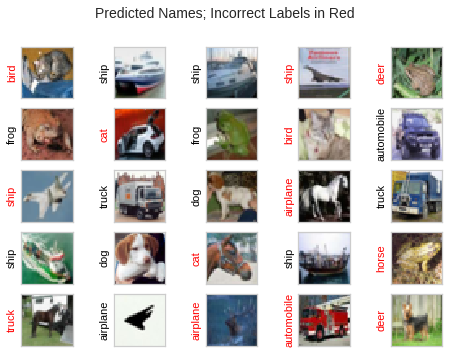

In [41]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i], cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(class_names[y_test_pred_svm[i]].split()[-1],
                   color='black' if y_test_pred_svm[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

This can be seen that the number of correct prediction is about 40%, just right to the accuracy rate.

#Confusion Matrix

In [42]:
conf_svm = confusion_matrix(y_test, y_test_pred_svm)
conf_svm

array([[518,  25,  63,  18,  31,  14,  28,  35, 212,  56],
       [ 45, 477,  36,  34,  30,  35,  43,  24,  82, 194],
       [110,  22, 344,  54, 173,  50, 131,  47,  44,  25],
       [ 42,  36,  99, 235,  91, 205, 132,  63,  35,  62],
       [ 65,  21, 184,  33, 398,  47, 139,  66,  27,  20],
       [ 30,  23, 121, 149,  81, 358, 113,  56,  37,  32],
       [ 19,  20, 105,  75, 143,  50, 523,  18,  14,  33],
       [ 54,  39,  63,  53, 139,  91,  60, 395,  34,  72],
       [ 83,  58,  20,  10,  25,  46,  14,  16, 646,  82],
       [ 59, 139,  18,  35,  19,  32,  31,  45, 106, 516]])

# Plot confusion matrix

Text(0.5, 1, 'Confusion Matrix')

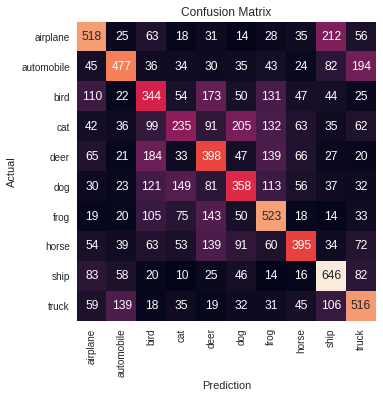

In [43]:
import seaborn as sns
mat_svm = confusion_matrix(y_test_pred_svm, y_test)
sns.heatmap(mat_svm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

#Sensitivity, Specificity and F1-Score 

In [44]:
from sklearn.metrics import classification_report
report_svm = classification_report(y_test, y_test_pred_svm,target_names=class_names, output_dict=True)
print(report_svm)

{'airplane': {'precision': 0.5053658536585366, 'recall': 0.518, 'f1-score': 0.5116049382716049, 'support': 1000}, 'automobile': {'precision': 0.5546511627906977, 'recall': 0.477, 'f1-score': 0.5129032258064515, 'support': 1000}, 'bird': {'precision': 0.32668566001899335, 'recall': 0.344, 'f1-score': 0.33511933755479784, 'support': 1000}, 'cat': {'precision': 0.33764367816091956, 'recall': 0.235, 'f1-score': 0.277122641509434, 'support': 1000}, 'deer': {'precision': 0.35221238938053095, 'recall': 0.398, 'f1-score': 0.3737089201877934, 'support': 1000}, 'dog': {'precision': 0.3857758620689655, 'recall': 0.358, 'f1-score': 0.37136929460580914, 'support': 1000}, 'frog': {'precision': 0.4308072487644152, 'recall': 0.523, 'f1-score': 0.4724480578139115, 'support': 1000}, 'horse': {'precision': 0.5163398692810458, 'recall': 0.395, 'f1-score': 0.44759206798866863, 'support': 1000}, 'ship': {'precision': 0.5222312045270816, 'recall': 0.646, 'f1-score': 0.5775592311130979, 'support': 1000}, 'tru

In [45]:
import pandas as pd
report_df_svm = pd.DataFrame(report_svm).transpose()
report_df_svm

,precision,recall,f1-score,support
airplane,0.505366,0.518,0.511605,1000.000
automobile,0.554651,0.477,0.512903,1000.000
bird,0.326686,0.344,0.335119,1000.000
cat,0.337644,0.235,0.277123,1000.000
deer,0.352212,0.398,0.373709,1000.000
dog,0.385776,0.358,0.371369,1000.000
frog,0.430807,0.523,0.472448,1000.000
horse,0.516340,0.395,0.447592,1000.000
ship,0.522231,0.646,0.577559,1000.000
truck,0.472527,0.516,0.493308,1000.000


#Perform Cross Validation with 3 folds

***This section may take hours to be executed***

In [46]:
from sklearn.model_selection import cross_val_score
cv_score_svm = cross_val_score(svm_clf, X_train_pca, y_train_1d, cv=3, scoring="accuracy")
cv_score_svm

array([0.5197696 , 0.51898962, 0.51818073])

In [47]:
# See the average of CV
np.mean(cv_score_svm)


0.5189799840148642

In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred_svm = cross_val_predict(svm_clf, X_train_pca, y_train_1d, cv=3)

Confusion Matrix & Accuracy

In [49]:
conf_cv_svm = confusion_matrix(y_train_1d, y_train_pred_svm)
conf_cv_svm

array([[2854,  214,  261,  148,  153,  107,  107,  150,  714,  292],
       [ 171, 3166,   93,  170,   71,   91,  113,  135,  274,  716],
       [ 421,  111, 1943,  377,  703,  311,  629,  256,  141,  108],
       [ 182,  140,  454, 1876,  264,  878,  603,  186,  167,  250],
       [ 291,   93,  732,  292, 2096,  240,  660,  351,  134,  111],
       [ 125,  125,  456, 1076,  337, 1917,  440,  284,  122,  118],
       [  71,   88,  409,  447,  541,  248, 2941,  102,   61,   92],
       [ 179,  114,  304,  348,  463,  301,  182, 2733,  105,  271],
       [ 465,  322,   94,  133,  100,  109,   61,   45, 3350,  321],
       [ 211,  734,   85,  166,   64,  110,  128,  153,  276, 3073]])

#Plot confusion matrix of Cross Validation

Text(0.5, 1, 'Confusion Matrix')

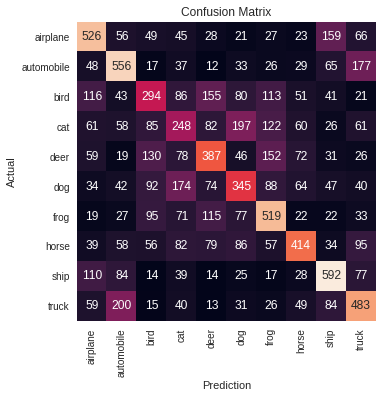

In [50]:
mat_cv = confusion_matrix(y_train_pred, y_train_1d)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

#Plots sensitivity and specificity against the number of folds

In [0]:
from sklearn.metrics import precision_recall_curve, roc_curve
precision_svm = report_df_svm['precision']
recall_svm = report_df_svm['recall']

![alt text](https://drive.google.com/uc?id=1MPln68-6AFUqBve0FEAcG7mNEYg_AiCm)

#ROC curve (Receiver Operating Characteristic curve)

![alt text](https://drive.google.com/uc?id=1dZyM8NN_rak-GiT7v9xrYU1dPvU5ISAT)

#Conclusion

In this CIFAR10 dataset contains training set 50000 images and testing set 10000 images, size 32 x 32. For visualization, many images and graphs were plotted in the begining. Normalization and scaling technique were not used because the dataset were all images. Instead, reshape and dimensionality reduction (PCA) was applied to fasten the learning speed. 
After new clean data is ready, both multiclass RandomForest and SVM models were creted.

After many experiments, running both models on testing dataset, the RandomForest model is considered poor performance. Both training time and accuracy performances are based on the n_estimator which is known as number of trees. This process is called pre-pruning. For instance, if the higher n_estimator is set, it results the higher accuracy and longer learning time also. Similarly, the SVM model is based on size of subset. For instance, if a bigger subset is chosen, it would result the higher accuracy and longer training. Cross Validation was used to validate both models, and its average scores were almost matched. Unfortunately, both models took very much time to run cross validation, with just k=3 folds, especially, the SVM model took almost an hour. Therefore, cross validation is not recommended for the SVM model.
Below are the two comparision charts of RandomForest and SVM model, based on training time and accuracies, .

![alt text](https://drive.google.com/uc?id=1nM6uP8AchikEwnO61pex8j8EpkzESLYR)

![alt text](https://drive.google.com/uc?id=1gg3eizKcDBd3RKVQqAqGcKEQ5AX150VY)

Overal, the performance of SVM model was much better than RandomForest in term of both training time and accuracy for this CIFAR10 dataset. Statically, the SVM model that used suset sized 5000, took only 8 seconds for training and produced 45% accurracy, is the winner.